## Supervised Learning Models
### Import Libraries and Load Data

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
df = pd.read_csv(r"C:\Users\madha\Downloads\12310219-PA\nasa_exoplanets.csv", sep=',')

#### =======================================
#### PLANET DISCOVERY METHOD CLASSIFICATION
#### =======================================
#### Features Selection

In [ ]:
features_A = [
    'pl_orbper',
    'pl_orbsmax',
    'pl_rade',
    'pl_bmasse',
    'st_teff',
    'st_mass',
    'st_rad',
    'sy_dist'
]
features_A = [f for f in features_A if f in df.columns]
df = df[features_A + ["discoverymethod"]].copy()
print("Initial shape:", df.shape)

Initial shape: (6061, 9)


#### Handle Missing Values

In [215]:
df = df.dropna(thresh=len(features_A) - 2)

for col in features_A:
    df[col] = df[col].fillna(df[col].median())

print("After cleaning shape:", df.shape)

After cleaning shape: (6061, 85)


#### Target Engineering

In [224]:
def simplify_discovery_method(method):
    method = str(method).lower()

    if method == 'transit':
        return 'Transit'
    elif method == 'radial velocity':
        return 'Radial Velocity'
    elif 'timing' in method:
        return 'Timing'
    elif method == 'microlensing':
        return 'Microlensing'
    elif method == 'imaging':
        return 'Imaging'
    elif method == 'astrometry':
        return 'Astrometry'
    else:
        return 'Other'

df["discovery_simple"] = df["discoverymethod"].apply(simplify_discovery_method)

print(df["discovery_simple"].value_counts())


discovery_simple
Transit            4472
Radial Velocity    1157
Microlensing        262
Imaging              89
Timing               66
Other                10
Astrometry            5
Name: count, dtype: int64


#### Reduce Class Imbalance

In [ ]:
class_counts = df["discovery_simple"].value_counts()
valid_classes = class_counts[class_counts >= 100].index
df = df[df["discovery_simple"].isin(valid_classes)]

print(df["discovery_simple"].value_counts())

discovery_simple
Transit            4472
Radial Velocity    1157
Microlensing        262
Name: count, dtype: int64


### Encoding and Train/Test Split

In [233]:
X = df[features_A]
y = df['discovery_simple']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (4123, 8)
Test size: (1768, 8)


### Train Multiple Models (Using Pipelines)

In [234]:
models_A = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000,class_weight="balanced"))]),
    
    "K-Nearest Neighbors": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=7, weights='distance'))
    ]),
    
    "Decision Tree": Pipeline([
        ("model", DecisionTreeClassifier(max_depth=5,class_weight="balanced", random_state=42))
    ])
}
results_A = {}

### Detailed Evaluation

In [235]:
for name, model in models_A.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_A[name] = f1_score(y_test, y_pred, average="macro")

results_A

{'Logistic Regression': 0.9134429940490766,
 'K-Nearest Neighbors': 0.9096777383222507,
 'Decision Tree': 0.9186450398297549}

In [236]:
dt_model = models_A["Decision Tree"]
y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        79
           1       0.72      0.97      0.83       347
           2       0.99      0.90      0.95      1342

    accuracy                           0.92      1768
   macro avg       0.90      0.95      0.92      1768
weighted avg       0.94      0.92      0.92      1768



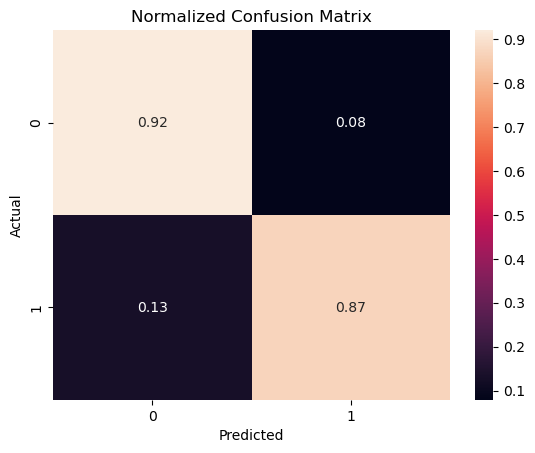

In [273]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

####  Feature Importance

In [300]:
dt_A = models_A["Decision Tree"].named_steps["model"]
# Feature importance
importance_A = dt_A.feature_importances_
fi_A = pd.DataFrame({
    "Feature": features_A,
    "Importance": importance_A
}).sort_values(by="Importance", ascending=True)
print(fi_A)

      Feature  Importance
4     st_teff    0.000350
2     pl_rade    0.001250
6      st_rad    0.009760
3   pl_bmasse    0.010368
0   pl_orbper    0.043102
5     st_mass    0.047078
1  pl_orbsmax    0.087794
7     sy_dist    0.800297


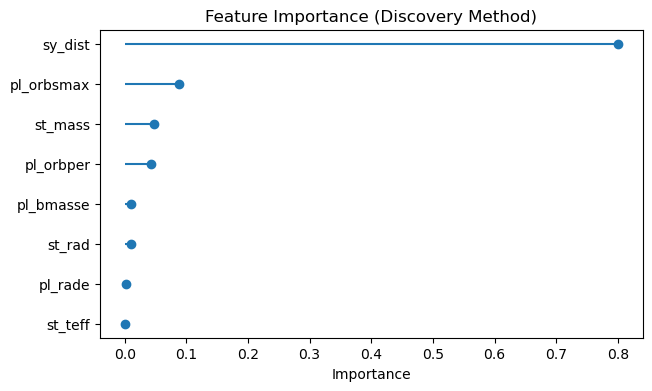

In [329]:
plt.figure(figsize=(7,4))
plt.hlines(
    y=fi_A["Feature"],
    xmin=0,
    xmax=fi_A["Importance"]
)
plt.plot(
    fi_A["Importance"],
    fi_A["Feature"],
    "o"
)
plt.xlabel("Importance")
plt.title("Feature Importance (Discovery Method)")
plt.show()

#### Domain Validation

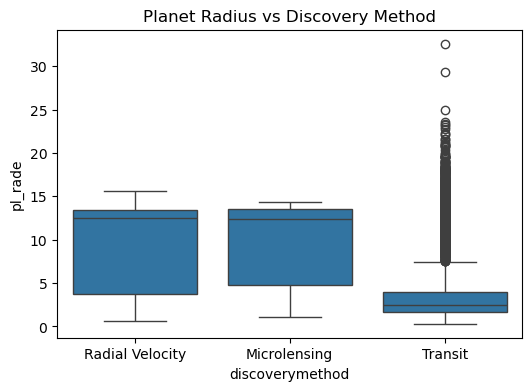

In [338]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x="discoverymethod",
    y="pl_rade",
    data=df
)
plt.title("Planet Radius vs Discovery Method")
plt.show()

### =========================================
###        TEMPERATURE CLASSIFICATION
### =========================================
#### Feature Selection & Cleaning

In [339]:
features_B = [
    "pl_orbper",
    "pl_rade",
    "pl_bmasse",
    "st_teff",
    "st_mass"
]

df_B = df[features_B + ["pl_eqt"]].copy()
for col in features_B + ["pl_eqt"]:
    df_B[col] = df_B[col].fillna(df_B[col].median())

#### Create Temperature Classes

In [340]:
def temperature_class(temp):
    if temp <= 300:
        return "Non-Hot"   
    else:
        return "Hot"

df_B["temp_class"] = df_B["pl_eqt"].apply(temperature_class)
df_B.drop(columns=["pl_eqt"], inplace=True)

print(df_B["temp_class"].value_counts())


temp_class
Hot        5735
Non-Hot     156
Name: count, dtype: int64


#### Encode Target

In [341]:
le_temp = LabelEncoder()
df_B["temp_class"] = le_temp.fit_transform(df_B["temp_class"])

#### Train/Test Split

In [342]:
X = df_B[features_B]
y = df_B["temp_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### Define Models

In [343]:
models_B = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced"
        ))
    ]),

    "Naive Bayes": Pipeline([
        ("scaler", StandardScaler()),
        ("model", GaussianNB())
    ]),

    "Decision Tree": Pipeline([
        ("model", DecisionTreeClassifier(
            max_depth=5,
            class_weight="balanced",
            random_state=42
        ))
    ])
}

#### Train & Evaluate

In [344]:
results_B = {}

for name, model in models_B.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_B[name] = f1_score(y_test, y_pred, average="macro")

results_B

{'Logistic Regression': 0.4814777225210596,
 'Naive Bayes': 0.57687338501292,
 'Decision Tree': 0.6597051111833531}

#### Detailed Evaluation

In [345]:
dt_temp = models_B["Decision Tree"]
y_pred_dt = dt_temp.predict(X_test)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1148
           1       0.23      0.87      0.36        31

    accuracy                           0.92      1179
   macro avg       0.61      0.90      0.66      1179
weighted avg       0.98      0.92      0.94      1179



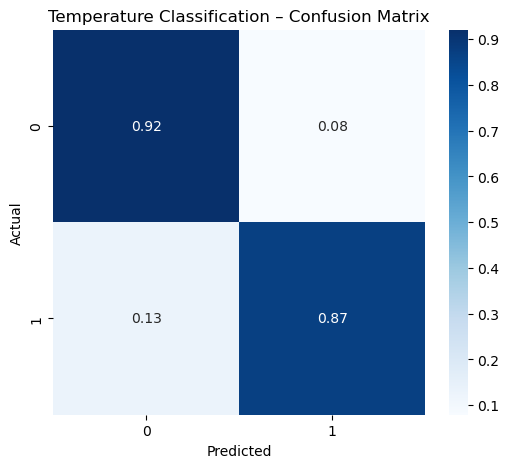

In [346]:
cm = confusion_matrix(y_test, y_pred_dt, normalize="true")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Temperature Classification – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Feature Importance

In [350]:
dt_B = models_B["Decision Tree"].named_steps["model"]

importance_B = dt_B.feature_importances_

fi_B = pd.DataFrame({
    "Feature": features_B,
    "Importance": importance_B
}).sort_values(by="Importance", ascending=True)

print(fi_B)

     Feature  Importance
1    pl_rade    0.036456
2  pl_bmasse    0.044129
3    st_teff    0.126807
4    st_mass    0.240911
0  pl_orbper    0.551698


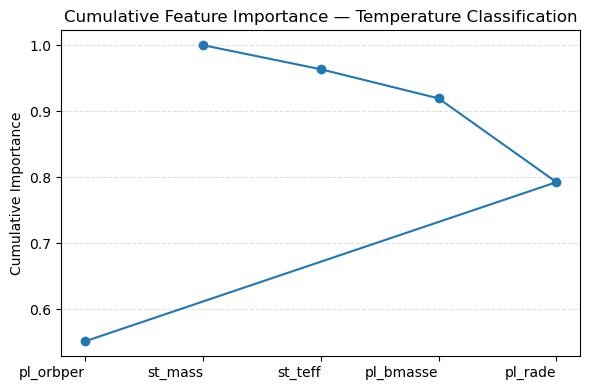

In [353]:
fi_sorted = fi_B.sort_values("Importance", ascending=False)
fi_sorted["Cumulative"] = fi_sorted["Importance"].cumsum()

plt.figure(figsize=(6,4))
plt.plot(
    fi_sorted["Cumulative"],
    marker="o"
)

plt.xticks(range(len(fi_sorted)), fi_sorted["Feature"],  ha="right")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance — Temperature Classification")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

#### Domain Validation

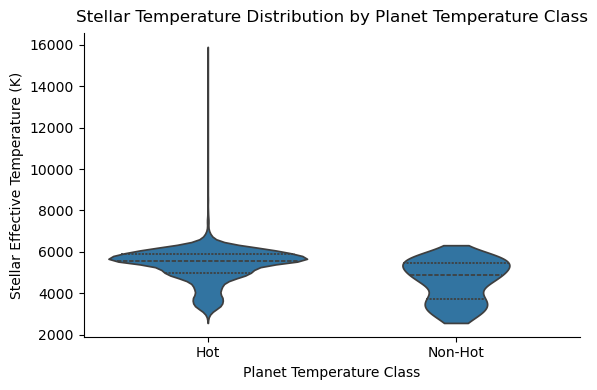

In [360]:
df_temp_plot = df_B.copy()
df_temp_plot["temp_label"] = le_temp.inverse_transform(df_temp_plot["temp_class"])
plt.figure(figsize=(6,4))

sns.violinplot(
    x="temp_label",
    y="st_teff",
    data=df_temp_plot,
    inner="quartile",
    cut=0
)

plt.xlabel("Planet Temperature Class")
plt.ylabel("Stellar Effective Temperature (K)")
plt.title("Stellar Temperature Distribution by Planet Temperature Class", pad=8)

sns.despine()
plt.tight_layout()
plt.show()
